In [16]:
import os
import librosa
import argparse
import numpy as np

import matplotlib.pyplot as plt

def process_label(file, t_unit=0.02):
    lines = None
    with open(file, 'r') as f:
        lines = f.readlines()
    queue = []
    base_note = librosa.note_to_midi("A0")
    for i in range(1, len(lines)):
        onset, offset, midi = lines[i].split('\t')
        onset, offset, midi = float(onset), float(offset), int(midi[:midi.find("\n")])
        start, end = round(onset/t_unit), round(offset/t_unit)
        pitch = midi - base_note
        queue.append([start, end, pitch])
    length = queue[-1][1] + 100
    pitch_width = 352       # base = 88 = 108-21
    base = 88
    label = np.zeros((length, pitch_width))
    scale = pitch_width // base
    for note in queue:
        on, off, p = note
        p_range = range(p*scale, (p+1)*scale)
        label[on:off, p_range] = 1
        #print(on,off,p,p_range,scale)
    print("Time (in sec) : ", length*t_unit)
    return label

Time (in sec) :  127.46000000000001


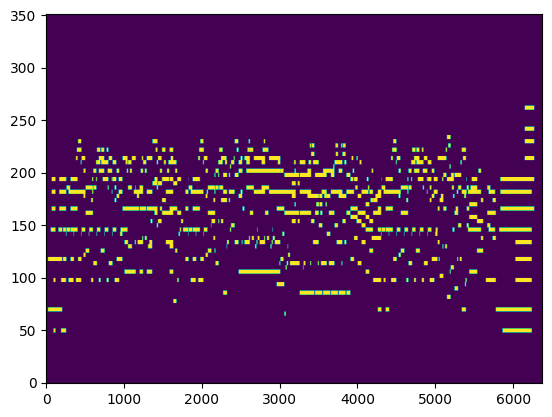

In [17]:
#label = process_label('../data/MAPS/AkPnCGdD/UCHO/I32-96/C0-2/MAPS_UCHO_C0-2_I32-96_S1_n10_AkPnCGdD.txt')
label = process_label('../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-alb_esp2_AkPnCGdD.txt')
plt.imshow(label.transpose(), aspect='auto', origin='lower')
plt.show()

In [29]:
import glob, pickle, os, sys
from tqdm import trange
import csv
import soundfile as sf
import h5py
from scipy import signal, fftpack

def ls_wavs(folder):
    if type(folder) == str:
        return glob.glob(os.path.join(folder, "*.wav"))
    else:
        files = []
        for i in folder:
            f = glob.glob(os.path.join(i, "*.wav"))
            files.append(f)
        return files
    
def Manage_Process_Label(files, save_path, num_per_file, t_unit=0.02):
    
    files = [ff.replace(".wav", ".txt") for ff in files]
    
    iters = np.ceil(len(files)/num_per_file).astype('int')
    for i in trange(iters):
        sub_files = files[i*num_per_file : (i+1)*num_per_file]
        
        labels = []
        for sf in sub_files:
            labels.append(process_label(sf, t_unit=t_unit))

        f_name = "train" if "train" in files[0] else "test"
        post   = "_{}_{}_label.pickle".format(num_per_file, i+1)
        f_name += post
        f_name = os.path.join(save_path, f_name)

        pickle.dump(labels, open(f_name, 'wb'), pickle.HIGHEST_PROTOCOL)


def fetch_harmonic(data, cenf, ith_har, 
                   start_freq=27.5, 
                   num_per_octave=48, 
                   is_reverse=False):
    
    ith_har += 1
    if ith_har != 0 and is_reverse:
        ith_har = 1/ith_har
    
    #harmonic_series = [12, 19, 24, 28, 31]     
    bins_per_note = int(num_per_octave / 12)           
    total_bins = int(bins_per_note * 88)
    
    hid = min(range(len(cenf)), key=lambda i: abs(cenf[i]-ith_har*start_freq))
    
    harmonic = np.zeros((total_bins, data.shape[1]))
    upper_bound = min(len(cenf)-1, hid+total_bins)
    harmonic[:(upper_bound-hid)] = data[hid:upper_bound]
    
    return harmonic

def nonlinear_func(X, g, cutoff):
    cutoff = int(cutoff)
    if g!=0:
        X[X<0] = 0
        X[:cutoff, :] = 0
        X[-cutoff:, :] = 0
        X = np.power(X, g)
    else:
        X = np.log(X)
        X[:cutoff, :] = 0
        X[-cutoff:, :] = 0
    return X

def STFT(x, fr, fs, Hop, h):        
    t = np.arange(Hop, np.ceil(len(x)/float(Hop))*Hop, Hop)
    N = int(fs/float(fr))
    window_size = len(h)
    f = fs*np.linspace(0, 0.5, np.round(N/2), endpoint=True)
    Lh = int(np.floor(float(window_size-1) / 2))
    tfr = np.zeros((int(N), len(t)), dtype=np.float)     
        
    for icol in range(0, len(t)):
        ti = int(t[icol])           
        tau = np.arange(int(-min([round(N/2.0)-1, Lh, ti-1])), \
                        int(min([round(N/2.0)-1, Lh, len(x)-ti])))
        indices = np.mod(N + tau, N) + 1
        tfr[indices-1, icol] = x[ti+tau-1] * h[Lh+tau-1] \
                                /np.linalg.norm(h[Lh+tau-1])           
                            
    tfr = abs(fftpack.fft(tfr, n=N, axis=0))  
    return tfr, f, t, N

def Freq2LogFreqMapping(tfr, f, fr, fc, tc, NumPerOct):
    StartFreq = fc
    StopFreq = 1/tc
    Nest = int(np.ceil(np.log2(StopFreq/StartFreq))*NumPerOct)
    central_freq = []

    for i in range(0, Nest):
        CenFreq = StartFreq*pow(2, float(i)/NumPerOct)
        if CenFreq < StopFreq:
            central_freq.append(CenFreq)
        else:
            break

    Nest = len(central_freq)
    freq_band_transformation = np.zeros((Nest-1, len(f)), dtype=np.float)
    for i in range(1, Nest-1):
        l = int(round(central_freq[i-1]/fr))
        r = int(round(central_freq[i+1]/fr)+1)
        #rounding1
        if l >= r-1:
            freq_band_transformation[i, l] = 1
        else:
            for j in range(l, r):
                if f[j] > central_freq[i-1] and f[j] < central_freq[i]:
                    freq_band_transformation[i, j] = (f[j] - central_freq[i-1]) / (central_freq[i] - central_freq[i-1])
                elif f[j] > central_freq[i] and f[j] < central_freq[i+1]:
                    freq_band_transformation[i, j] = (central_freq[i + 1] - f[j]) / (central_freq[i + 1] - central_freq[i])
    tfrL = np.dot(freq_band_transformation, tfr)
    return tfrL, central_freq

def Quef2LogFreqMapping(ceps, q, fs, fc, tc, NumPerOct):
    StartFreq = fc
    StopFreq = 1/tc
    Nest = int(np.ceil(np.log2(StopFreq/StartFreq))*NumPerOct)
    central_freq = []

    for i in range(0, Nest):
        CenFreq = StartFreq*pow(2, float(i)/NumPerOct)
        if CenFreq < StopFreq:
            central_freq.append(CenFreq)
        else:
            break
    f = 1/q
    Nest = len(central_freq)
    freq_band_transformation = np.zeros((Nest-1, len(f)), dtype=np.float)
    for i in range(1, Nest-1):
        for j in range(int(round(fs/central_freq[i+1])), int(round(fs/central_freq[i-1])+1)):
            if f[j] > central_freq[i-1] and f[j] < central_freq[i]:
                freq_band_transformation[i, j] = (f[j] - central_freq[i-1])/(central_freq[i] - central_freq[i-1])
            elif f[j] > central_freq[i] and f[j] < central_freq[i+1]:
                freq_band_transformation[i, j] = (central_freq[i + 1] - f[j]) / (central_freq[i + 1] - central_freq[i])
    
    tfrL = np.dot(freq_band_transformation[:, :len(ceps)], ceps)
    return tfrL, central_freq

def CFP_filterbank(x, fr, fs, Hop, h, fc, tc, g, NumPerOctave):
    NumofLayer = np.size(g)

    [tfr, f, t, N] = STFT(x, fr, fs, Hop, h)
    tfr = np.power(abs(tfr), g[0])
    tfr0 = tfr # original STFT
    ceps = np.zeros(tfr.shape)


    if NumofLayer >= 2:
        for gc in range(1, NumofLayer):
            if np.remainder(gc, 2) == 1:
                tc_idx = round(fs*tc)
                ceps = np.real(np.fft.fft(tfr, axis=0))/np.sqrt(N)
                ceps = nonlinear_func(ceps, g[gc], tc_idx)
            else:
                fc_idx = round(fc/fr)
                tfr = np.real(np.fft.fft(ceps, axis=0))/np.sqrt(N)
                tfr = nonlinear_func(tfr, g[gc], fc_idx)
    
    tfr0 = tfr0[:int(round(N/2)),:]
    tfr = tfr[:int(round(N/2)),:]
    ceps = ceps[:int(round(N/2)),:]
    

    HighFreqIdx = int(round((1/tc)/fr)+1)
    f = f[:HighFreqIdx]
    tfr0 = tfr0[:HighFreqIdx,:]
    tfr = tfr[:HighFreqIdx,:]
    HighQuefIdx = int(round(fs/fc)+1)
    q = np.arange(HighQuefIdx)/float(fs)
    ceps = ceps[:HighQuefIdx,:]
    
    tfrL0, central_frequencies = Freq2LogFreqMapping(tfr0, f, fr, fc, tc, NumPerOctave)
    tfrLF, central_frequencies = Freq2LogFreqMapping(tfr, f, fr, fc, tc, NumPerOctave)
    tfrLQ, central_frequencies = Quef2LogFreqMapping(ceps, q, fs, fc, tc, NumPerOctave)

    return tfrL0, tfrLF, tfrLQ, f, q, t, central_frequencies 

def feature_extraction(filename,Hop=882,w=7939,fr=1.0,fc=27.5,tc=1/4487.0,g=[0.24, 0.6, 1],NumPerOctave=48,Down_fs=16000):
                       
    x, fs = sf.read(filename)
    if len(x.shape)>1:
       x = np.mean(x, axis = 1)
    #x = x[:3*fs]
    x = signal.resample_poly(x, Down_fs, fs)
    fs = Down_fs # sampling frequency
    x = x.astype('float32')
    #Hop = 320 # hop size (in sample)
    h = signal.blackmanharris(w) # window size
    #fr = 2.0 # frequency resolution
    #fc = 27.5#80.0 # the frequency of the lowest pitch
    #tc = 1/4487.0#1/1000.0 # the period of the highest pitch
    #g = np.array([0.24, 0.6, 1])
    g = np.array(g)
    #NumPerOctave = 48 # Number of bins per octave
    #f  --> freq for each axis

    MaxSample = 15000
    samples = np.floor(len(x)/Hop).astype('int')
    print("# Sample: ", samples)
    if samples > MaxSample:
        freq_width = MaxSample * Hop
        Round = np.ceil(samples/MaxSample).astype('int')
        tmpL0, tmpLF, tmpLQ, tmpZ = [], [], [], []
        for i in range(Round):
            tmpX = x[i*freq_width:(i+1)*freq_width]
            tfrL0, tfrLF, tfrLQ, f, q, t, CenFreq = CFP_filterbank(tmpX, fr, fs, Hop, h, fc, tc, g, NumPerOctave)
            tmpL0.append(tfrL0)
            tmpLF.append(tfrLF)
            tmpLQ.append(tfrLQ)
            tmpZ.append(tfrLF*tfrLQ)

        tfrL0 = tmpL0.pop(0)
        tfrLF = tmpLF.pop(0)
        tfrLQ = tmpLQ.pop(0)
        Z = tmpZ.pop(0)
        for i in range(Round-1):
            tfrL0 = np.concatenate((tfrL0, tmpL0.pop(0)), axis=1)
            tfrLF = np.concatenate((tfrLF, tmpLF.pop(0)), axis=1)
            tfrLQ = np.concatenate((tfrLQ, tmpLQ.pop(0)), axis=1)
            Z = np.concatenate((Z, tmpZ.pop(0)), axis=1)
    else:
        tfrL0, tfrLF, tfrLQ, f, q, t, CenFreq = CFP_filterbank(x, fr, fs, Hop, h, fc, tc, g, NumPerOctave)
        Z = tfrLF * tfrLQ

    return Z, tfrL0, tfrLF, tfrLQ, t, CenFreq, f

def make_dataset_audio(dataset_name, song_list, fmt=".hdf",harmonic=False,num_harmonic=0):
    
    fs = 44100
    if harmonic:
        freq_range = [1.0, fs/2]
    else:
        freq_range = [27.5, 4487.0]
    
    hdf_out = h5py.File(dataset_name+fmt, "w")

    
    
    for idx, song in enumerate(song_list):
        print("Extracting({}/{}): {}".format(idx+1, len(song_list), song))
        
        out  = feature_extraction(song, fc=freq_range[0], tc=(1/freq_range[1]), Down_fs=fs)
        cenf = out[5]
        #z, spec, gcos, ceps, cenf = out[0:5]

        piece = np.transpose(np.array(out[0:4]), axes=(2, 1, 0))
        
        if harmonic:
            har = []
            for i in range(num_harmonic+1):
                har.append(fetch_harmonic(out[1], cenf, i))
            har_s = np.transpose(np.array(har), axes=(2, 1, 0))
            
            har = []
            for i in range(num_harmonic+1):
                har.append(fetch_harmonic(out[3], cenf, i, is_reverse=True))
            har_c = np.transpose(np.array(har), axes=(2, 1, 0))
            
            piece = np.dstack((har_s, har_c))
        
        hdf_out.create_dataset(str(idx), data=piece, compression="gzip", compression_opts=5)
    
    hdf_out.close()    

def Manage_Feature_Process(songs, save_path, save_name, fmt = '.hdf', num_per_file=40, harmonic=True, permutate=False):
    #songs = os.listdir(audio_path)
    #songs = [os.path.join(audio_path, ss) for ss in songs]

    if permutate:
        songs = np.random.permutation(songs)
    with open(os.path.join(save_path, "songlist.csv"), 'w', newline='') as c:
        writer = csv.writer(c)
        writer.writerow(["File Name", "id", "Save Path"])
        n = len(songs) // num_per_file
        if n == 0:
            n = 1
        for i in range(n):
            print("Files " + str(i+1) + "/" + str(n))
            sub_list = songs[(i*num_per_file):((i+1)*num_per_file)]
            sub_name = os.path.join(save_path, (save_name + '_' + str(i+1)))
            make_dataset_audio(sub_name, sub_list, fmt, harmonic=harmonic, num_harmonic=5)

            # write record to file
            for id in sub_list:
                f_name = save_name + '_' + str(i+1)
                id = id[(id.rfind('/')+1):]
                writer.writerow([f_name, id, save_path])

In [30]:
'''
parser = argparse.ArgumentParser(description="Program to process MAPS features for training and testing.")
parser.add_argument("--MAPS-path", 
                    help="Path to your downloaded MAPS folder path. (default: %(default)s)",
                    type=str, default="./")
parser.add_argument("--train-num-per-file", 
                    help="Number of pieces to be stored in each output train file (default: %(default)d)",
                    type=int, default=20)
parser.add_argument("--test-num-per-file", 
                    help="Number of pieces to be stored in each output test file (default: %(default)d)",
                    type=int, default=10)
parser.add_argument("--save-path",
                    help="Path for saving the output files (default: <MAPS>/features)",
                    type=str)
parser.add_argument("--no-harmonic",
                    help="Wether to generate harmonic features (HCFP, 12 channels) or CFP features only(4 channels).",
                    action="store_true")
args = parser.parse_args()
'''

train_folders = ["AkPnCGdD"]
test_folders = ["ENSTDkAm"]
train_folders = [os.path.join('../data/MAPS', ff, "MUS") for ff in train_folders]
test_folders  = [os.path.join('../data/MAPS', ff, "MUS") for ff in test_folders]

train_songs = ls_wavs(train_folders)
test_songs = ls_wavs(test_folders)

train_save_path = os.path.join('../savepath', 'train')
if not os.path.exists(train_save_path):
       os.makedirs(train_save_path)
test_save_path = os.path.join('../savepath', "test")
if not os.path.exists(test_save_path):
    os.makedirs(test_save_path)
    
train_save_name = "train_" + str(20)
test_save_name  = "test_" + str(10)
print(train_songs)
# Process training features
Manage_Feature_Process(train_songs, train_save_path, train_save_name, num_per_file=20)
Manage_Process_Label(train_songs, "../savepath", 20)

# Process testing features
Manage_Feature_Process(test_songs, test_save_path, test_save_name, num_per_file=10)
Manage_Process_Label(test_songs, "../savepath", 10) 

[['../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn-p14_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-br_im5_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-alb_esp2_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-schu_143_2_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn-p11-format0_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn_op10_e12_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-ty_februar_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-liz_et6_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-mz_333_2_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-grieg_kobold_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-liz_et5_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-muss_2_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-liz_et_trans5_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-schub_d960_3_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-liz_rhap02_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-alb_esp3_AkPnCGdD.wav', '../data/MAP

TypeError: Invalid file: ['../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn-p14_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-br_im5_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-alb_esp2_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-schu_143_2_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn-p11-format0_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn_op10_e12_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-ty_februar_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-liz_et6_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-mz_333_2_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-grieg_kobold_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-liz_et5_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-muss_2_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-liz_et_trans5_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-schub_d960_3_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-liz_rhap02_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-alb_esp3_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn-p15_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-bk_xmas5_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn-p20_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-scn16_4_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chp_op18_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn_op27_1_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-waldstein_2_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn-p13_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn_op10_e01_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn-p7_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-mendel_op53_5_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-chpn-p11_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-br_im2_AkPnCGdD.wav', '../data/MAPS/AkPnCGdD/MUS/MAPS_MUS-bor_ps1_AkPnCGdD.wav']

In [1]:
from IPython.display import Audio


Audio('../stereo_file1.wav')